# How to break a neural network


We're going to use neural networks to make correct predictions!

THEN WE'RE GOING TO BREAK THEM.

In [1]:
# a bajillion imports
import shutil
import requests
import tempfile
import os
caffe_root = '/opt/caffe/'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

caffe_root = '/opt/caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Load the labels (so we know whether 242 means 'adorable puppy' or 'garbage can')
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

In [3]:
# Set Caffe to CPU mode because who even knows how to set up a GPU (not me)
caffe.set_mode_cpu()

# Load our model! trained by the GOOGLES! <3
def load_model():
    BATCH_SIZE = 1
    net = caffe.Net('/opt/caffe/models/bvlc_googlenet/deploy.prototxt',
                    '/models/bvlc_googlenet.caffemodel',
                    caffe.TEST)
    # change batch size to 1 for faster processing
    # this just means that we're only processing one image at a time instead of like 50
    shape = list(net.blobs['data'].data.shape)
    shape[0] = BATCH_SIZE
    net.blobs['data'].reshape(*shape)
    net.blobs['prob'].reshape(BATCH_SIZE, )
    net.reshape() 
    return net
net = load_model()
# Caffe comes with a handy transformer pipeline so that
# we can make our images into the format it needs! Yay!
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

If we're going to look at pictures of adorable dogs & pandas, we need a way to download them from the internet! This does that, and saves it to a png on our disk.

In [4]:
def get_png_image(url):
    fd, path = tempfile.mkstemp()
    tmpfile = os.fdopen(fd, "wb")
    response = requests.get(url, stream=True)
    shutil.copyfileobj(response.raw, tmpfile)
    if 'png' in url:
        !mv {path} {path}.png
    else:
        !convert {path} {path}.png
    path = path + ".png"
    return transformer.preprocess('data', caffe.io.load_image(path))

Now, let's start with a simple classification. We feed in the image (with some preprocessing) and classify with a forward pass.

In [5]:
cat_data = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))

In [6]:
print cat_data.shape

(3, 224, 224)


Great! The 3 means RGB, and the image is 224x224 pixels.

In [7]:
net.blobs['data'].data[...] = cat_data
out = net.forward()
pred_class = out['prob'][0].argmax()
print("Predicted class is #{}.".format(pred_class))

Predicted class is #282.


What did the input look like?

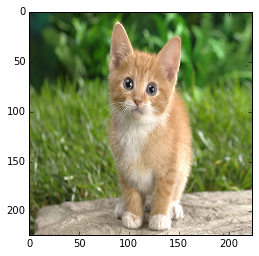

In [8]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

Adorable, but was our classification correct?

In [9]:
print labels[pred_class]

n02123159 tiger cat


Looks right! Let's put all that together into a couple of functions -- `predict()` will make a prediction & show the image.

In [10]:
def display(data):
    plt.imshow(transformer.deprocess('data', data))

def predict(data, n_preds=6, display_output=True):
    net.blobs['data'].data[...] = data
    if display_output:
        display(data)
    prob = net.forward()['prob']
    probs = prob[0]
    prediction = probs.argmax()
    top_k = probs.argsort()[::-1]
    for pred in top_k[:n_preds]:
        percent = round(probs[pred] * 100, 2)
        # display it compactly if we're displaying more than the top prediction
        if n_preds == 1:
            format_string = "class: {cls}\nlabel: {label}\ncertainty: {certainty}%"
        else:
            format_string = "class: {cls}, label: {label}, certainty: {certainty}%"
        if display_output:
            print format_string.format(
                cls=pred, label=labels[pred], certainty=percent)
    return prob

class: 388
label: n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
certainty: 99.57%


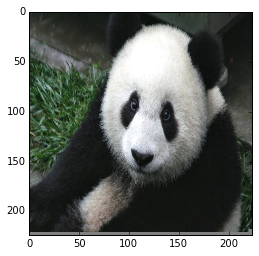

In [11]:
panda_url = 'https://upload.wikimedia.org/wikipedia/commons/c/cd/Panda_Cub_from_Wolong,_Sichuan,_China.JPG'
panda_data = get_png_image(panda_url)
probs = predict(panda_data, n_preds=1)

class: 412
label: n02747177 ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin
certainty: 40.58%


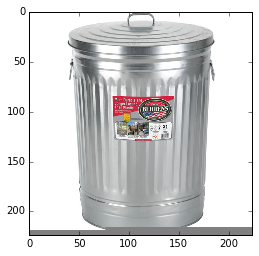

In [12]:
garbage_url = 'http://www.behrensmfg.com/wp-content/uploads/1270-31-gallon-trash-can.jpg'
garbage_data = get_png_image(garbage_url)
probs = predict(garbage_data, n_preds=1)

class: 623
label: n03658185 letter opener, paper knife, paperknife
certainty: 77.63%


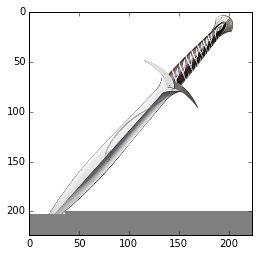

In [13]:
sword_url = 'http://a.tgcdn.net/images/products/zoom/f2bc_sting_the_sword_of_bilbo_baggins.jpg'
sword_data = get_png_image(sword_url)
probs = predict(sword_data, n_preds=1)

class: 285
label: n02124075 Egyptian cat
certainty: 34.57%


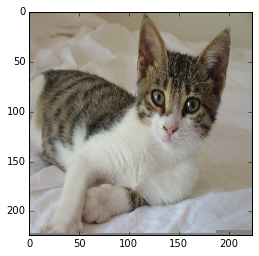

In [14]:
kitten_url = 'https://upload.wikimedia.org/wikipedia/commons/b/b9/CyprusShorthair.jpg'
kitten_data = get_png_image(kitten_url)
probs = predict(kitten_data, n_preds=1)

class: 263
label: n02113023 Pembroke, Pembroke Welsh corgi
certainty: 42.77%


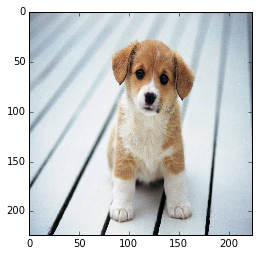

In [15]:
dog_url = 'http://cdn.playbuzz.com/cdn/7820ec56-cd7d-487c-87ba-30ca87219dc4/26084bf6-4235-4f8f-9c2f-b7294ea62c15.jpg'
dog_data = get_png_image(dog_url)
probs = predict(dog_data, n_preds=1)

class: 793
label: n04209133 shower cap
certainty: 99.7%


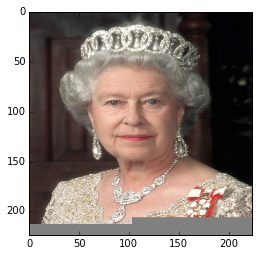

In [16]:
queen_url = 'http://www.librarising.com/astrology/celebs/images2/QR/queenelizabethii.jpg'
queen_data = get_png_image(queen_url)
probs = predict(queen_data, n_preds=1)

Here's a good example where the network has 2 options it's about equally sure of:

class: 716, label: n03930313 picket fence, paling, certainty: 63.82%
class: 912, label: n04604644 worm fence, snake fence, snake-rail fence, Virginia fence, certainty: 36.12%
class: 646, label: n03733281 maze, labyrinth, certainty: 0.01%
class: 753, label: n04040759 radiator, certainty: 0.01%
class: 888, label: n04532670 viaduct, certainty: 0.01%
class: 825, label: n04326547 stone wall, certainty: 0.0%


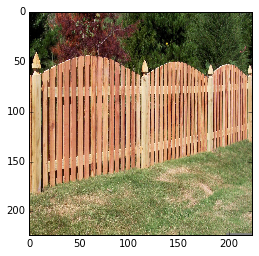

In [17]:
fence_url = 'http://jmarvinhandyman.com/wp-content/uploads/2014/04/fence-mossy-oak-wood-shadowbox_1373304.jpg'
fence_data = get_png_image(fence_url)
probs = predict(fence_data, n_preds=6)

# Intentionally breaking the predictions.

Now it's time for the fun part. When is a garbage can not a garbage can?

When it's a cocktail shaker, or a water jug.

When is a panda not a panda?

When it's another furry mammal. Let me show you what I mean and stop making silly jokes.

In [18]:
net = load_model()

In [19]:
input_data = panda_data

First, let's just predict our panda again:

class: 388
label: n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
certainty: 99.57%


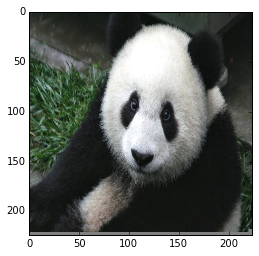

In [20]:
output = predict(input_data, n_preds=1)

Just a normal panda. No big deal. Now, let's calculate the gradient of the network there! This is the direction that changes the output probabilities the most.

We compute the gradient using something called 'backpropagation'. This is the most confusing part of this whole thing and I'm not going to explain it terribly well here.

In [21]:
def compute_gradient(probs):
    backout = net.backward(prob=probs)
    return backout['data'].copy()

In [22]:
grad = compute_gradient(output)

What does it look like? Because the gradient is the same shape as the the panda itself, we can just display it as an image!. We need to scale it up to make it really visible though.

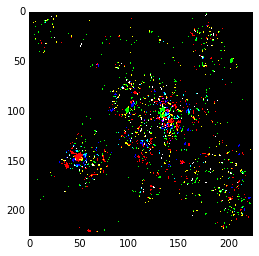

In [23]:
display(grad / np.percentile(grad, 98))

Okay, now here's the trick. We want to maximize the amount we're going to change our output probabilities by. Near our image, the probabilities look like

$$ P(x + \text{delta}) =  P(x) + \text{delta} \cdot \text{grad}$$

where the gradient `grad` is $\nabla P(x)$. So we want to maximize the dot product of the direction we're moving `delta` and the gradient `grad`. We've already calculated `grad` via our `compute_gradient()` function, and drawn it as a picture.

The intuition behind what we want to do is -- we want to create a `delta` which emphasizes the pixels in the picture that the neural network thinks is important. Let's do it in code now, and hopefully what we're doing will become here.

<small>
(I'm lying a little here -- what we're trying to manipulate isn't actually the probabilities directly, but instead something called the *loss function*. But the idea is the same.)
</small>

First, let's pick a random direction and see what $ \text{delta} \cdot \text{grad} $ is

In [24]:
delta_random = np.random.randint(-1, 1, grad.shape)
np.sum(grad * delta_random)

-1.5703404201428128e-06

So that's a pretty small change in probability. Now, let's suppose `grad` was $(-0.01, -0.01, 0.01, 0.02, 0.03)$.

We could make $\text{grad} \cdot \text{delta}$ big by taking $\text{delta} = (-1, -1, 1, 1, 1)$, to get 0.08. Let's try that! In code, that'll be `delta = np.sign(grad)`

In [25]:
delta = np.sign(grad)
np.sum(grad * delta)

0.12801658

That's much more significant! Like, 12%! Let's see if adding that delta to our image makes a big change in the classification.

In [26]:
net = load_model()

class: 356
label: n02441942 weasel
certainty: 25.82%


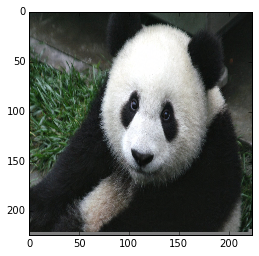

In [27]:
_ = predict(panda_data - 0.75 * delta, n_preds=1)

NOW IT THINKS OUR PANDA IS A WEASEL. WE ARE GODS.

Let's just reprise that one more time:

Panda:

class: 388
label: n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
certainty: 99.57%


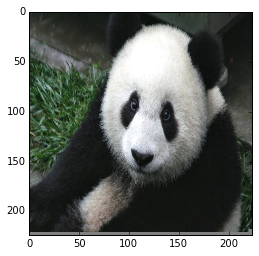

In [28]:
_  = predict(panda_data, n_preds=1)

Panda moved by the carefully crafted delta designed to trick the network:

class: 356
label: n02441942 weasel
certainty: 25.82%


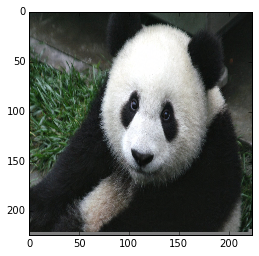

In [29]:
_  = predict(panda_data - 0.75 * delta, n_preds=1)

# Making tricking into a function

Let's make the process for choosing how much to move the image by into a function!

In [30]:
def delta_to_trick_network(input_data):
    probs = predict(input_data, n_preds=1, display_output=False)
    grad = compute_gradient(probs)
    delta = np.sign(grad)
    return delta

## The garbage can

In [48]:
delta = delta_to_trick_network(garbage_data)

class: 412, label: n02747177 ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin, certainty: 40.58%
class: 899, label: n04560804 water jug, certainty: 11.03%


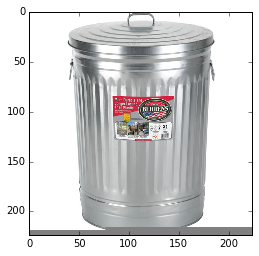

In [49]:
_ = predict(garbage_data, n_preds=2)

class: 899, label: n04560804 water jug, certainty: 22.69%
class: 503, label: n03062245 cocktail shaker, certainty: 14.12%


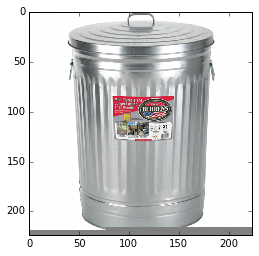

In [50]:
_ = predict(garbage_data - 0.75 * delta, n_preds=2)

We can also make the network **more** sure it's a garbage can:

class: 412, label: n02747177 ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin, certainty: 84.98%
class: 463, label: n02909870 bucket, pail, certainty: 2.77%


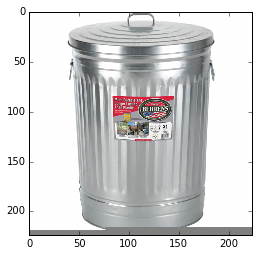

In [51]:
_ = predict(garbage_data + 0.75 * delta, n_preds=2)

Let's draw the gradient, because that's fun:

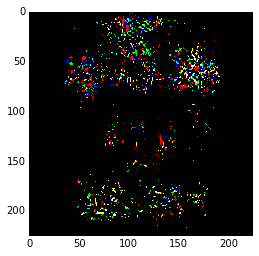

In [55]:
probs = predict(garbage_data, display_output=False)
grad = compute_gradient(probs)
display(grad / np.percentile(grad, 98))

## A black screen

Let's start with a black image:

class: 885, label: n04525038 velvet, certainty: 27.38%
class: 794, label: n04209239 shower curtain, certainty: 6.4%
class: 911, label: n04599235 wool, woolen, woollen, certainty: 6.19%
class: 700, label: n03887697 paper towel, certainty: 4.67%
class: 904, label: n04589890 window screen, certainty: 4.39%
class: 741, label: n03998194 prayer rug, prayer mat, certainty: 3.14%


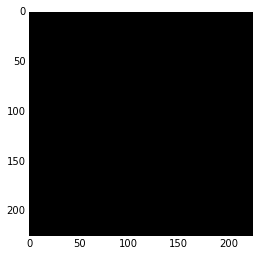

In [40]:
black = np.zeros_like(grad) * 255
_ = predict(black)

27% likely to be velvet? I can work with that! Let's convince the network that it's 100% likely to be velvet! We just use the same trick as before, except in a loop.

class: 885, label: n04525038 velvet, certainty: 30.68%
class: 911, label: n04599235 wool, woolen, woollen, certainty: 5.85%
class: 885, label: n04525038 velvet, certainty: 51.01%
class: 911, label: n04599235 wool, woolen, woollen, certainty: 6.54%
class: 885, label: n04525038 velvet, certainty: 70.09%
class: 911, label: n04599235 wool, woolen, woollen, certainty: 5.82%
class: 885, label: n04525038 velvet, certainty: 82.92%
class: 911, label: n04599235 wool, woolen, woollen, certainty: 4.66%
class: 885, label: n04525038 velvet, certainty: 91.66%
class: 911, label: n04599235 wool, woolen, woollen, certainty: 2.38%
class: 885, label: n04525038 velvet, certainty: 96.57%
class: 911, label: n04599235 wool, woolen, woollen, certainty: 1.34%
class: 885, label: n04525038 velvet, certainty: 98.07%
class: 911, label: n04599235 wool, woolen, woollen, certainty: 0.53%
class: 885, label: n04525038 velvet, certainty: 98.93%
class: 911, label: n04599235 wool, woolen, woollen, certainty: 0.55%
class: 8

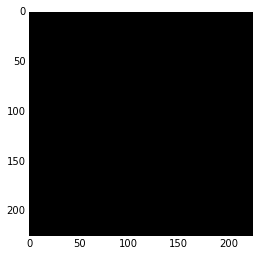

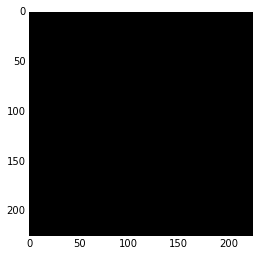

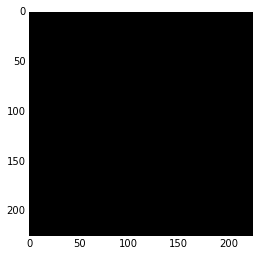

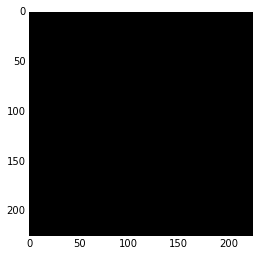

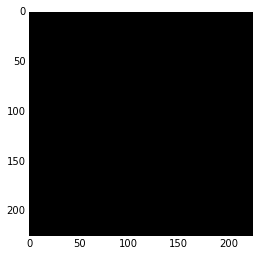

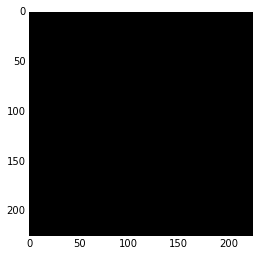

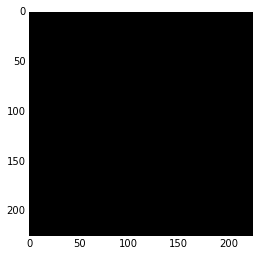

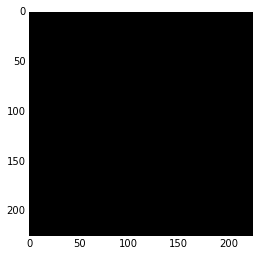

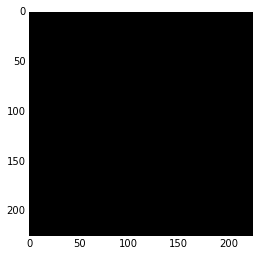

In [41]:
net = load_model()
black = np.zeros_like(grad) * 255
for _ in range(9):
    delta = delta_to_trick_network(black)
    plt.figure()
    black = black + 0.1 * delta
    predict(black, display_output=True, n_preds=2)

This is really neat! We can see the probability that the image is velvet increase from 30% to 99.6%, and the final image still appears totally black:

class: 885
label: n04525038 velvet
certainty: 99.62%


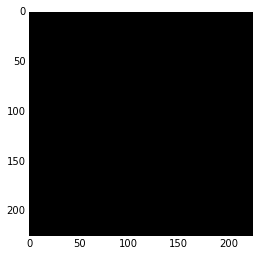

In [42]:
_ = predict(black, n_preds = 1)

If we look at it more carefully, though, we see it's not really black! It has hundreds of tiny differences from black that have tricked the neural network into thinking that it's velvet. And we got them by repeatedly making small steps along the gradient (gradient ascent!). We are wizards.

In [43]:
black

array([[[[ 0.30000001,  0.9000001 ,  0.5       , ...,  0.30000001,
          -0.1       ,  0.10000002],
         [ 0.70000005,  0.5       ,  0.10000002, ..., -0.10000002,
           0.1       ,  0.1       ],
         [ 0.5       ,  0.30000001, -0.5       , ..., -0.1       ,
           0.09999999,  0.1       ],
         ..., 
         [ 0.1       ,  0.30000001, -0.1       , ..., -0.09999999,
           0.30000001,  0.5       ],
         [ 0.30000001,  0.30000001,  0.10000002, ...,  0.30000001,
           0.5       ,  0.70000005],
         [ 0.5       ,  0.70000005,  0.30000001, ...,  0.30000001,
           0.5       , -0.30000001]],

        [[ 0.10000002,  0.9000001 ,  0.70000005, ...,  0.5       ,
           0.5       ,  0.10000002],
         [ 0.5       ,  0.5       ,  0.1       , ..., -0.10000002,
           0.5       ,  0.5       ],
         [ 0.5       ,  0.5       , -0.30000001, ..., -0.5       ,
           0.09999999,  0.30000001],
         ..., 
         [-0.5       , -0.5     

We can do the same thing to some light-coloured noise, and convince the network that it's a paper towel :)

class: 700, label: n03887697 paper towel, certainty: 22.44%
class: 549, label: n03291819 envelope, certainty: 21.02%
class: 700, label: n03887697 paper towel, certainty: 41.04%
class: 549, label: n03291819 envelope, certainty: 16.34%
class: 700, label: n03887697 paper towel, certainty: 66.14%
class: 549, label: n03291819 envelope, certainty: 7.57%
class: 700, label: n03887697 paper towel, certainty: 85.06%
class: 549, label: n03291819 envelope, certainty: 2.46%
class: 700, label: n03887697 paper towel, certainty: 94.02%
class: 434, label: n02808304 bath towel, certainty: 1.21%
class: 700, label: n03887697 paper towel, certainty: 97.65%
class: 434, label: n02808304 bath towel, certainty: 0.85%
class: 700, label: n03887697 paper towel, certainty: 98.67%
class: 999, label: n15075141 toilet tissue, toilet paper, bathroom tissue, certainty: 0.64%
class: 700, label: n03887697 paper towel, certainty: 99.23%
class: 999, label: n15075141 toilet tissue, toilet paper, bathroom tissue, certainty: 

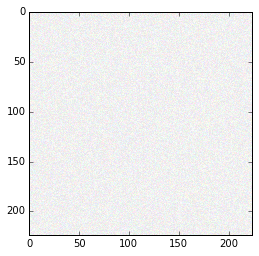

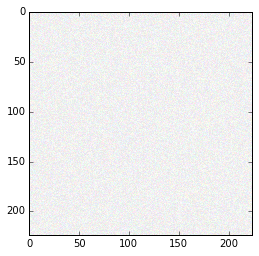

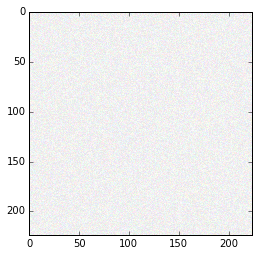

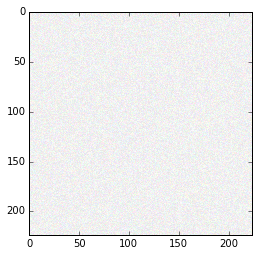

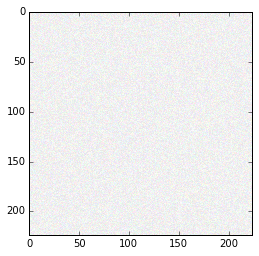

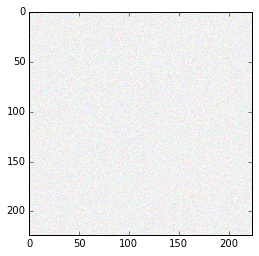

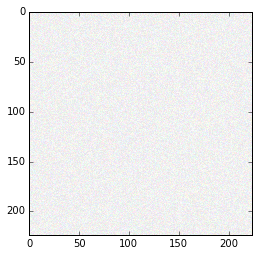

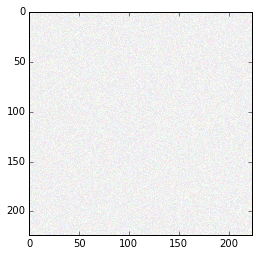

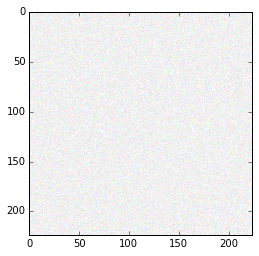

In [47]:
net = load_model()
noise = np.random.randint(227, 255, grad.shape)
for _ in range(9):
    delta = delta_to_trick_network(noise)
    plt.figure()
    noise = noise + 0.1 * delta
    predict(noise, display_output=True, n_preds=2)